In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch

/Users/1X/Library/Python/3.8/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


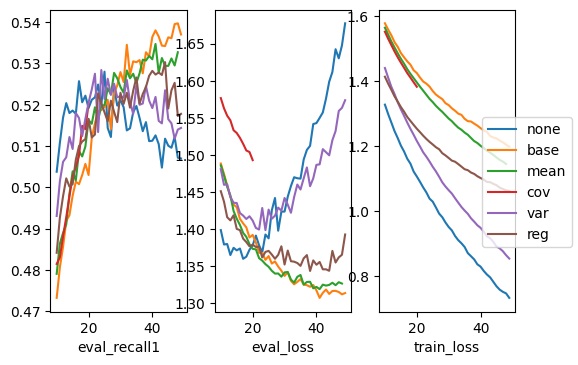

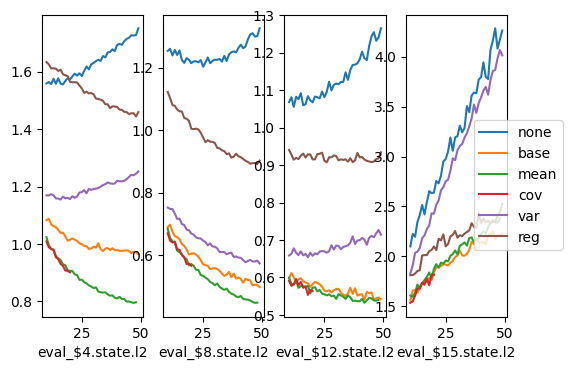

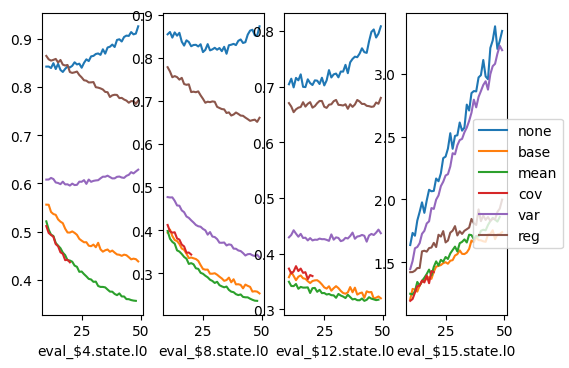

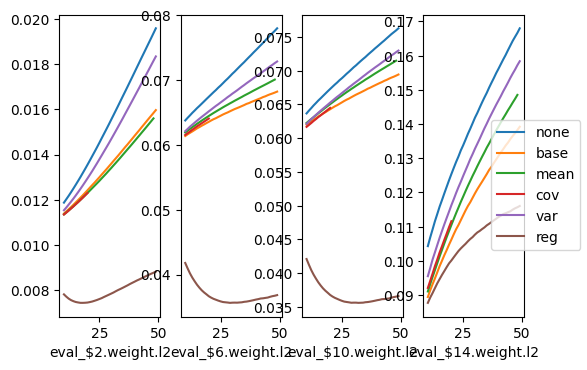

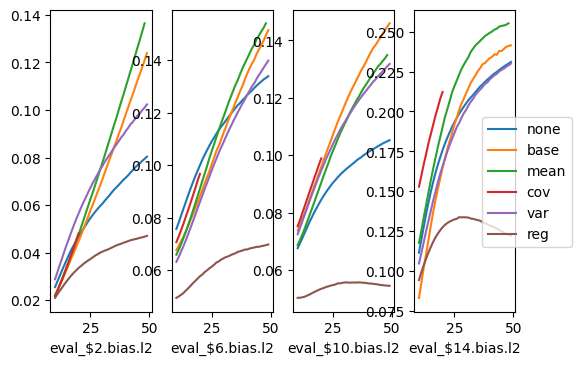

In [152]:
def read_df_map(group, tags):
    df_map = {}
    for tag in tags:
        try:
            df_map[tag] = pd.read_json(f"outputs/{group}/{tag}_1/logs.json")
        except:
            pass
    return df_map

def rowplots(df_map, labels, start=10, sharex=True, sharey=False):
    fig, axes = plt.subplots(
        1, len(labels),
        sharex=sharex, sharey=sharey, 
        facecolor="w", dpi=100)
    if len(labels) == 1:
        axes = [axes]
    for ax, label in zip(axes, labels):
        for tag, df in df_map.items():
            x, y = [], []
            if label in df.columns:
                df = df[df.index >= start][label]
                x, y = df.index, df.values
            ax.plot(x, y, label=tag)
        ax.set_xlabel(label)
    fig.legend(*axes[0].get_legend_handles_labels(), "right")

group, tags = "schemes", ("none", "base", "mean", "cov", "var", "reg")
#group, tags = "layers", ("l", "l1", "l2", "l12", "l3", "l13", "l23", "l123")
df_map = read_df_map(group, tags)
rowplots(df_map, ["eval_recall1", "eval_loss", "train_loss"])
rowplots(df_map, [f"eval_${i}.state.l2" for i in (4, 8, 12, 15)])
rowplots(df_map, [f"eval_${i}.state.l0" for i in (4, 8, 12, 15)])
rowplots(df_map, [f"eval_${i}.weight.l2" for i in (2, 6, 10, 14)])
rowplots(df_map, [f"eval_${i}.bias.l2" for i in (2, 6, 10, 14)])

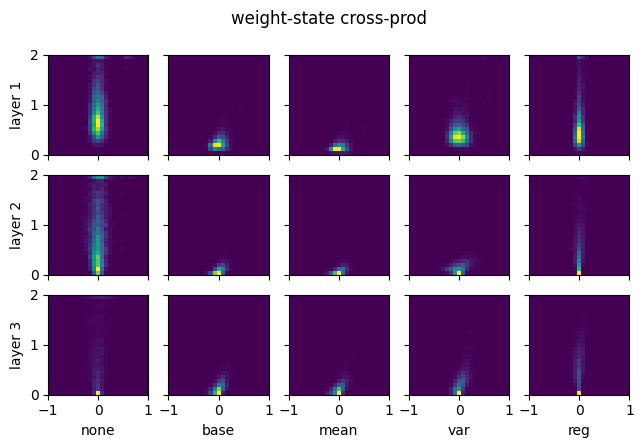

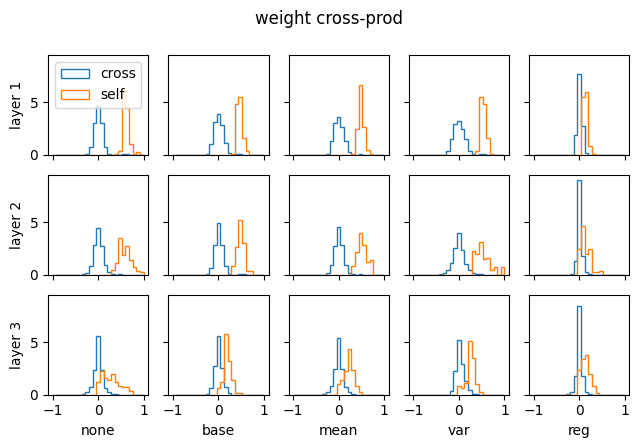

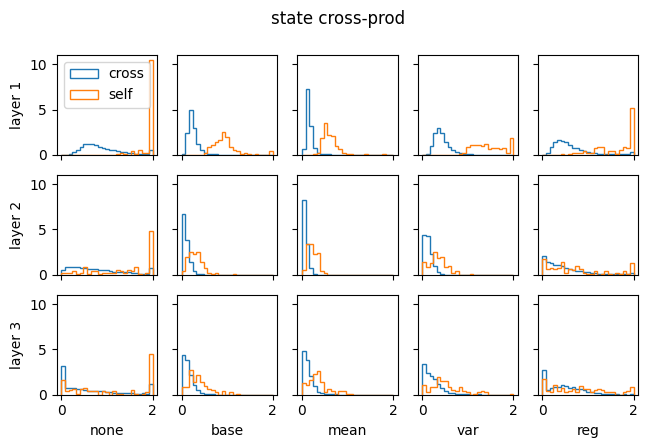

In [157]:
def outer(x):
    return x.unsqueeze(-1) * x.unsqueeze(-2)

def std(m1, m2):
    return (m2.diagonal() - m1.square()).clip(min=0).sqrt()

def cov(m1, m2):
    return m2 - outer(m1)

def corr(m1, m2):
    return cov(m1, m2) / outer(std(m1, m2))

def read_state(state, i, training, sign):
    mode = "train" if training else "eval"
    postfix = "p" if sign else ""
    s0 = state[f"{i}.{mode}_agg.s0"]
    s1 = state[f"{i}.{mode}_agg.s1{postfix}"]
    s2 = state[f"{i}.{mode}_agg.s2{postfix}"]
    return s1 / s0, s2 / s0

def read_weight(state, i):
    w = state[f"{i}.weight"]
    return w.mean(1), w.T @ w

def gridplot(title, xlabels, ylabels):
    nrows, ncols = len(ylabels), len(xlabels)
    fig, axes = plt.subplots(
        nrows, ncols, sharex=True, sharey=True, 
        figsize=(ncols*1.5, nrows*1.5), dpi=100, facecolor="w")
    fig.suptitle(title)
    for i in range(ncols):
        axes[nrows-1][i].set_xlabel(xlabels[i])
    for i in range(nrows):
        axes[i][0].set_ylabel(ylabels[i])
    return axes

def setplot(group, tags, layers, term, ranges, fn):
    ax_xy = gridplot(f"weight-state {term}", tags, layers)
    ax_x = gridplot(f"weight {term}", tags, layers)
    ax_y = gridplot(f"state {term}", tags, layers)
    for i, tag in enumerate(tags):
        state = torch.load(f"outputs/{group}/{tag}_1/checkpoint-{epoch}.pt")
        for j, _ in enumerate(layers):
            w_m1, w_m2 = read_weight(state["model"], j*4+6)
            s_m1, s_m2 = read_state(state["model"], j*4+4, True)
            x = fn(w_m1, w_m2).clip(min=ranges[0][0], max=ranges[0][1])
            y = fn(s_m1, s_m2).clip(min=ranges[1][0], max=ranges[1][1])
            ax_xy[j][i].hist2d(x.flatten().numpy(), y.flatten().numpy(), range=ranges, bins=(25, 25))
            kwargs = {"bins": 25, "histtype": "step", "density": True}
            ax_x[j][i].hist(x.flatten().numpy(), range=ranges[0], label="cross", **kwargs)
            ax_x[j][i].hist(x.diagonal().numpy(), range=ranges[0], label="self", **kwargs)
            ax_y[j][i].hist(y.flatten().numpy(), range=ranges[1], label="cross", **kwargs)
            ax_y[j][i].hist(y.diagonal().numpy(), range=ranges[1], label="self", **kwargs)
    ax_x[0][0].legend()
    ax_y[0][0].legend()

group, tags = "schemes", ("none", "base", "mean", "var", "reg")
#group, tags = "layers", ("l", "l1", "l2", "l12", "l3", "l13", "l23", "l123")
layers = [f"layer {i+1}" for i in range(3)]
epoch = 50
#term, ranges, fn = "mean", ((-1/16, 1/16), (0, 2)), lambda m1, m2: m1
#term, ranges, fn = "std", ((0, 1), (0, 2)), std
term, ranges, fn = "cross-prod", ((-1/1, 1/1), (0, 2/1)), lambda m1, m2: m2
#term, ranges, fn = "covariance", ((-1/1, 1/1), (-1/1, 1/1)), cov
#term, ranges, fn = "correlation", ((-1, 1), (-1, 1)), corr
setplot(group, tags, layers, term, ranges, fn)